# The preliminaries

> Let real matrix $\mathbf{X} \in \mathbb{R}^{p \times q}$ have rank $r$ and economy SVD $\mathbf{U}\mathbf{S}\mathbf{V}^T = \mathbf{X}$ with $\mathbf{S} \in \mathbb{R}^{r\times r}$.

Since we can always transpose $\mathbf{X}$ such that there are more rows than columns, pick $p > q$.

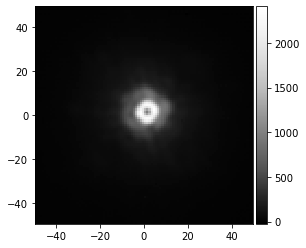

In [110]:
naco_betapic_preproc = np.load('./naco_betapic_preproc.npz')
image_cube = naco_betapic_preproc['cube']
dd.imshow(np.average(image_cube, axis=0))
# image_cube -= np.average(image_cube, axis=0)
angles = naco_betapic_preproc['angles']

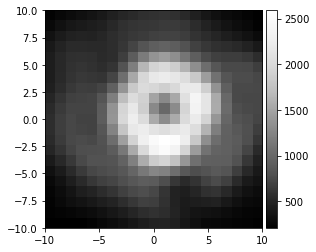

In [111]:
orig_n_pix = 100
crop = 40
crop_cube = image_cube[:,crop:-(crop-1),crop:-(crop-1)]

n_frames, image_shape = crop_cube.shape[0], crop_cube.shape[1:]
n_pix = image_shape[0] * image_shape[1]
crop_imvecs = crop_cube.reshape(n_frames, n_pix).T

dd.imshow(crop_imvecs[:,0].reshape(image_shape))

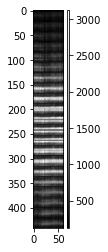

In [112]:
dim_p = n_pix
dim_q = n_frames
mtx_x = crop_imvecs
dd.matshow(mtx_x)

With the SVD given by $\mathbf{X}_{p \times q} = \mathbf{U}_{p \times r} \mathbf{S}_{r \times r} \mathbf{V}_{r \times q}^T$. For the thin svd, $r = q$; for a truncated SVD $r \le q$.

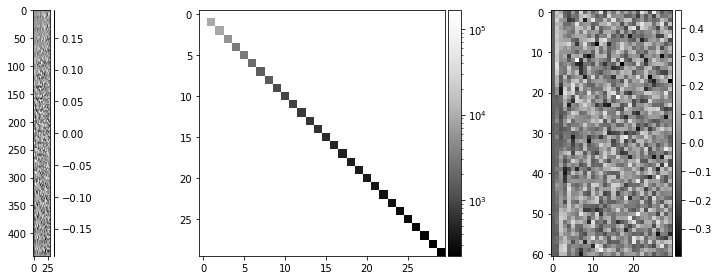

In [113]:
# dim_r = dim_q
dim_r = 30
mtx_u, diag_s, mtx_vt = np.linalg.svd(mtx_x, full_matrices=False)
mtx_u = mtx_u[:,:dim_r]
diag_s = diag_s[:dim_r]
mtx_s = np.diag(diag_s)
mtx_v = mtx_vt[:dim_r].T
fig, axs = plt.subplots(ncols=3, figsize=(12, 4))
dd.matshow(mtx_u, ax=axs[0])
dd.matshow(mtx_s, ax=axs[1], log=True)
dd.matshow(mtx_v, ax=axs[2])
plt.tight_layout()

We want to zero out columns 1 and 2. To do so we construct $\mathbf{A}$, a new matrix with $c$ columns containing the data we're removing multiplied by -1, and $\mathbf{B}$ a $q \times c$ matrix of (mostly) zeros where each column has a 1 entry in the row corresponding to the column of $\mathbf{X}$ we're removing.

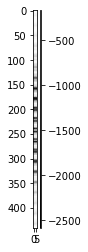

In [114]:
drop_min, drop_max = 3, 10
dim_c = drop_max - drop_min
mtx_a = -mtx_x[:,drop_min:drop_max]
dd.matshow(mtx_a)

In [115]:
mtx_b = np.zeros((dim_q, dim_c))
for b_col_idx, a_col_idx in zip(range(dim_c), range(drop_min, drop_max)):
    mtx_b[a_col_idx, b_col_idx] = 1
mtx_b

array([[0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
 

Forming the product $\mathbf{A} \mathbf{B}^T$ should give us something with the dimensions $p \times q$ that is the negative of $\mathbf{X}$ in the columns we're removing and zero elsewhere.

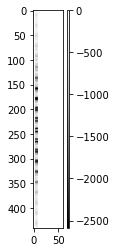

In [116]:
mtx_abt = mtx_a @ mtx_b.T
dd.matshow(mtx_abt)

Indeed, adding to $\mathbf{X}$ gives $\mathbf{X}' = \mathbf{X} + \mathbf{A}\mathbf{B}^T$, the updated (downdated) matrix.

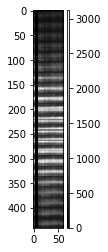

In [117]:
mtx_xprime = mtx_x + mtx_abt
dd.matshow(mtx_xprime)

In [118]:
def show_svd(mtx):
    mtx_u, diag_s, mtx_vt = np.linalg.svd(mtx, full_matrices=False)
    mtx_s = np.diag(diag_s)
    mtx_v = mtx_vt.T
    fig, axs = plt.subplots(ncols=3, figsize=(12, 4))
    dd.matshow(mtx_u, ax=axs[0], cmap='RdBu_r')
    dd.matshow(mtx_s, ax=axs[1], log=True)
    dd.matshow(mtx_v, ax=axs[2], cmap='RdBu_r')
    plt.tight_layout()
    return mtx_u, mtx_s, mtx_v

In [119]:
def compare_u(init_u, final_u, first_n=None, display=False):
    signs = np.zeros(init_u.shape[1])
    for col in range(init_u.shape[1]):
        signs[col] = 1 if np.allclose(init_u[:,col], final_u[:,col]) else -1
    vmax = np.max(np.abs([init_u, final_u]))
    final_u_mod = signs * final_u
    if display:
        import matplotlib.pyplot as plt
        fig, (ax_iu, ax_fu, ax_du) = plt.subplots(ncols=3, figsize=(14, 4))
        dd.matshow(init_u, vmin=-vmax, vmax=vmax, ax=ax_iu)
        ax_iu.set_title(r'$\mathbf{U}_\mathrm{first}$')
        dd.matshow(final_u_mod, vmin=-vmax, vmax=vmax, ax=ax_fu)
        ax_fu.set_title(r'(signs) * $\mathbf{U}_\mathrm{second}$')
        diff_vmax = np.max(np.abs(final_u_mod - init_u))
        dd.matshow(final_u_mod - init_u, cmap='RdBu_r', vmax=diff_vmax, vmin=-diff_vmax, ax=ax_du)
        ax_du.set_title(r'(signs) * $\mathbf{U}_\mathrm{second}$ - $\mathbf{U}_\mathrm{first}$')
    return np.allclose(final_u_mod[:,:first_n], init_u[:,:first_n])

Now we want to examine how the SVD has changed. The new singular vectors and values will be called

$$\mathbf{X}' = \mathbf{U}_\text{final} \mathbf{S}_\text{final} \mathbf{V}_\text{final}^T$$

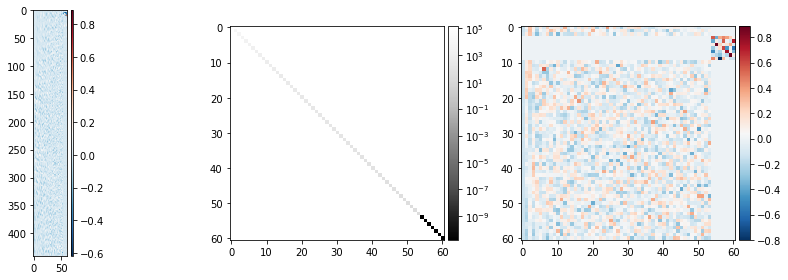

In [120]:
mtx_u_final, mtx_s_final, mtx_v_final = show_svd(mtx_xprime)

How does this compare to the SVD of the matrix with the columns removed entirely instead of zeroed? Let's call $\mathbf{X}_\text{drop}$ the matrix with its first and second columns dropped.

In [121]:
mtx_x_drop = np.delete(mtx_xprime, np.arange(drop_min, drop_max), axis=1)

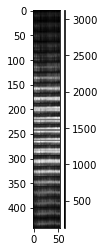

In [122]:
dd.matshow(mtx_x_drop)

The SVD is $$\mathbf{X}_\text{drop} = \mathbf{U}_\text{drop} \mathbf{S}_\text{drop} \mathbf{V}_\text{drop}^T$$

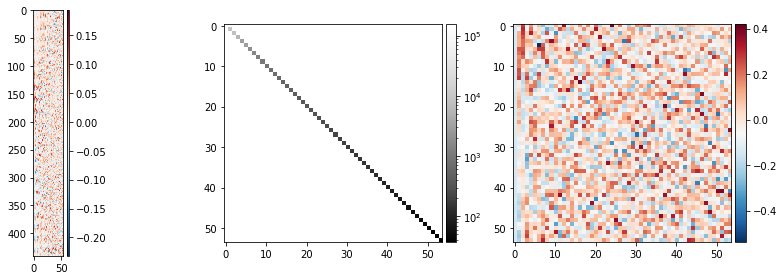

In [123]:
mtx_u_drop, mtx_s_drop, mtx_v_drop = show_svd(mtx_x_drop)

True

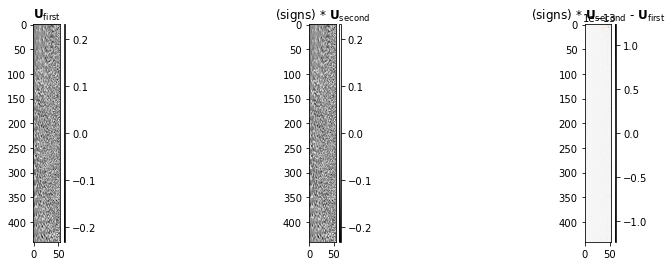

In [124]:
compare_u(mtx_u_drop, mtx_u_final[:,:dim_q - dim_c], display=True)

The first two columns of $\mathbf{U}$ agree, which is all we need since those are the only ones corresponding to nonzero singular values.

Recall that SVD can be equivalently expressed as the sum of singular value triplets $\vec{u}_i s_i \vec{v}_i^T$ where $\vec{u}_i$ is column $i$ of $\mathbf{U}_\text{final}$, $s_i$ is diagonal entry $i$ of $\mathbf{S}_\text{final}$, and $\vec{v}_i$ is column $i$ of $\mathbf{V}_\text{final}$.

To verify that only the $\vec{u}_i$ corresponding to nonzero singular values are required, calculate
$$
\mathbf{X}'_\text{Recons} = \vec{u}_1 s_1 \vec{v}_1^T + \vec{u}_2 s_2 \vec{v}_2^T
$$

and compare it to $\mathbf{X}'$.

**TODO** not quite right any more

In [125]:
# mtx_xprime_recons = (
#     np.outer(mtx_u_final[:,0] * mtx_s_final[0,0], mtx_v_final[:,0].T) +
#     np.outer(mtx_u_final[:,1] * mtx_s_final[1,1], mtx_v_final[:,1].T) +
#     np.outer(mtx_u_final[:,2] * mtx_s_final[2,2], mtx_v_final[:,2].T)
# )
# np.allclose(mtx_xprime, mtx_xprime_recons)

In [126]:
# dd.three_panel_diff_plot(mtx_xprime, mtx_xprime_recons, diff_kwargs={'as_percent': False})
# np.allclose(mtx_xprime, mtx_xprime_recons)

The columns of the resulting $\mathbf{X}'$ correspond to rows of $\mathbf{V}$, so to reproduce $\mathbf{X}_\text{drop}$ we simply delete the second and third rows of $\mathbf{V}_\text{final}$ and call that $\mathbf{V}_\text{final,drop}$.

Then we have
$$
    \mathbf{X}_\text{drop,recons} = \mathbf{U}_\text{final} \mathbf{S}_\text{final} \mathbf{V}_\text{final,drop}^T
$$

In [127]:
mtx_v_final_drop = np.delete(mtx_v_final, np.arange(drop_min, drop_max), axis=0)

In [128]:
mtx_x_drop_recons = mtx_u_final @ mtx_s_final @ mtx_v_final_drop.T
np.allclose(mtx_x_drop_recons, mtx_x_drop)

True

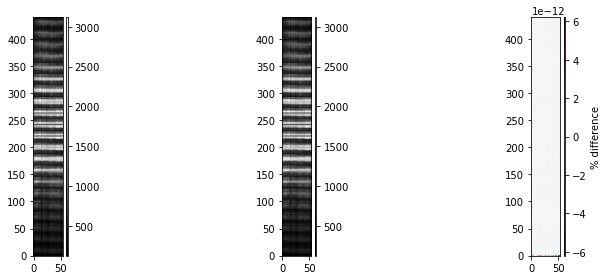

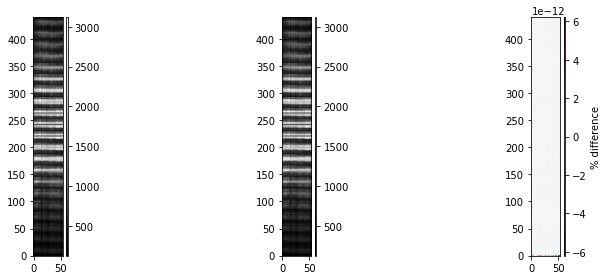

In [129]:
dd.three_panel_diff_plot(mtx_x_drop_recons, mtx_x_drop)

# The actual trick

It's possible to express the modification $\mathbf{X} + \mathbf{A} \mathbf{B}^T$ as modifications to $\mathbf{U}$ and $\mathbf{V}$ as follows

> $$ 
\mathbf{X} + \mathbf{A} \mathbf{B}^T = [\mathbf{U}\quad\mathbf{A}]
\begin{bmatrix}
\mathbf{S} & \mathbf{0}\\
\mathbf{0} & \mathbf{I} 
\end{bmatrix}
[\mathbf{V}\quad\mathbf{B}]^T
$$

In [130]:
mtx_u_a = np.hstack([mtx_u, mtx_a])
mtx_v_b = np.hstack([mtx_v, mtx_b])
mtx_s_i = np.eye(mtx_u_a.shape[1])
mtx_s_i[:mtx_s.shape[0],:mtx_s.shape[0]] = mtx_s

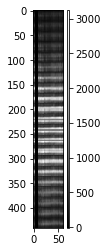

In [131]:
dd.matshow(mtx_u_a @ mtx_s_i @ mtx_v_b.T)

> Let $\mathbf{P}$ be an orthogonal basis of the column space of $(\mathbf{I} - \mathbf{U}\mathbf{U}^T)\mathbf{A}$ — the component of $\mathbf{A}$ that is orthogonal to $\mathbf{U}$ — and set $\mathbf{R_A} = \mathbf{P}^T(\mathbf{I} - \mathbf{U}\mathbf{U}^T)\mathbf{A}$.

In [132]:
def modified_gram_schmidt(matrix_a, in_place=False):
    """Orthonormalize the columns of `matrix_a` by the
    modified Gram-Schmidt algorithm.

    Parameters
    ----------
    matrix_a : array, shape (n, m)
        Matrix whose column vectors are to be orthonormalized
        (must be real, and float or double if not in-place)
    in_place : boolean, default: False
        Whether to modify `matrix_a` in-place or copy it

    Returns
    -------
    matrix_a : array, shape (n, m)
        Orthonormalized copy of `matrix_a`, unless `in_place` is set
    """
    if not in_place:
        matrix_a = matrix_a.astype(np.float64)
    n = matrix_a.shape[1]
    for k in range(n):
        norm = np.linalg.norm(matrix_a[:, k])
        if norm != 0:
            matrix_a[:, k] /= norm
        for j in range(k+1, n):
            matrix_a[:, j] -= np.vdot(matrix_a[:, j],
                                      matrix_a[:, k]) * matrix_a[:, k]
    return matrix_a

def orthonormalize(matrix_a):
    '''
    '''
    # Benchmarked against a somewhat optimized numpy implementation of MGS,
    # confirmed that calculating R along the way is a negligible
    # cost in time
    matrix_q, matrix_r = np.linalg.qr(matrix_a)
    return matrix_q

In [133]:
mtx_a_orth_u = (np.eye(dim_p) - mtx_u @ mtx_u.T) @ mtx_a
mtx_p, temp_r = np.linalg.qr(mtx_a_orth_u)
mtx_ra = mtx_p.T @ mtx_a_orth_u
dim_d = mtx_p.shape[1]

mtx_uta = mtx_u.T @ mtx_a
mtx_u_p = np.hstack([mtx_u, mtx_p])
mtx_uta_ra = np.vstack([mtx_uta, mtx_ra])

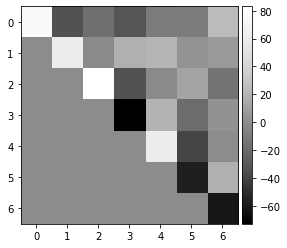

In [134]:
dd.matshow(temp_r)

In [135]:
mtx_p.shape == (dim_p, dim_c)

True

Since $\mathbf{U} \in \mathbb{R}^{p \times r}$, $\mathbf{A} \in \mathbb{R}^{p \times c}$, then $\mathbf{U^T}\mathbf{A} \in \mathbb{R}^{r \times c}$ and $\mathbf{P} \in \mathbb{R}^{p \times c}$

This will determine the amount by which the diagonal matrix needs to be padded to construct $\mathbf{K}$.

True

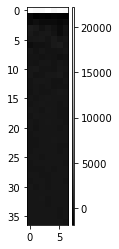

In [136]:
dd.matshow(mtx_uta_ra)
mtx_uta_ra.shape == (dim_r + dim_c, dim_c)

> Similarly, let $\mathbf{Q}\mathbf{R_B} = (\mathbf{I} - \mathbf{V}\mathbf{V}^T) \mathbf{B}$

$$
  [\mathbf{V}\quad\mathbf{Q}]
\begin{bmatrix}
\mathbf{I} & \mathbf{V^T}\mathbf{B}\\
\mathbf{0} & \mathbf{R_B}
\end{bmatrix} \leftarrow [\mathbf{V}\quad\mathbf{B}]
$$


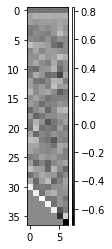

In [137]:
mtx_b_orth_v = (np.eye(dim_q) - mtx_v @ mtx_v.T) @ mtx_b
mtx_q, temp_r = np.linalg.qr(mtx_b_orth_v)
mtx_rb = mtx_q.T @ mtx_b_orth_v
dim_f = mtx_q.shape[1]

mtx_vtb = mtx_v.T @ mtx_b
mtx_v_q = np.hstack([mtx_v, mtx_q])
mtx_vtb_rb = np.vstack([mtx_vtb, mtx_rb])
dd.matshow(mtx_vtb_rb)

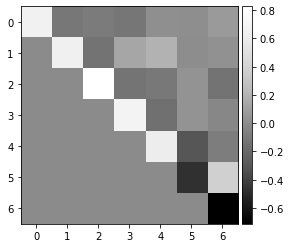

In [138]:
dd.matshow(temp_r)

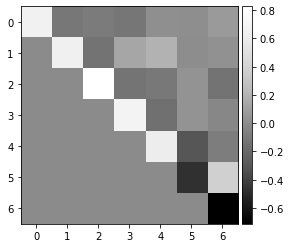

In [139]:
dd.matshow(mtx_rb)

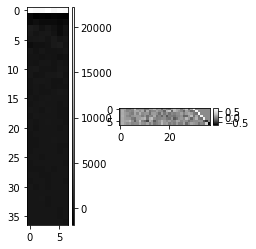

In [140]:
plt.subplot(131)
dd.matshow(mtx_uta_ra)
plt.subplot(132)
dd.matshow(mtx_vtb_rb.T)

## TODO: What is the interpretation of $\mathbf{R_A}$ and $\mathbf{R_B}$

Since they are both zero, they can maybe be omitted from the construction of $\mathbf{K}$? The resulting decomposition is then a rotation $\mathbf{U}'$ of $\mathbf{U}$ instead of $[\mathbf{U}\quad\mathbf{P}]$ and $\mathbf{V}$ is adjusted similarly.

In [141]:
# np.allclose(np.zeros((2,2)), mtx_ra @ mtx_rb)

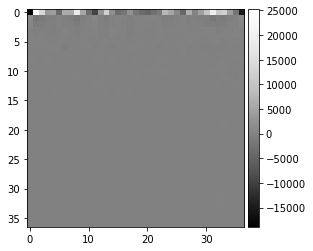

In [142]:
mtx_k_second_term = mtx_uta_ra @ mtx_vtb_rb.T
dd.matshow(mtx_k_second_term)
pad_rows = dim_d
pad_cols = dim_f
mtx_k = np.pad(mtx_s, [(0, dim_d), (0, dim_f)]) + mtx_k_second_term

In [143]:
mtx_k = mtx_s + mtx_uta @ mtx_vtb.T

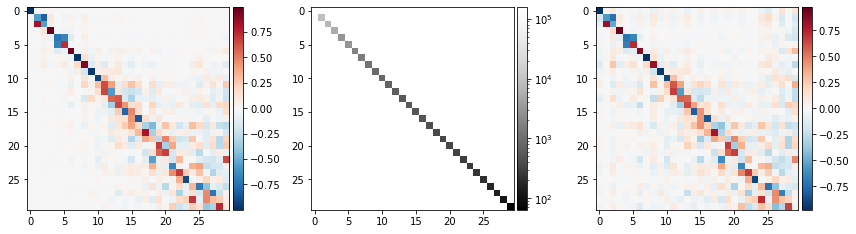

In [144]:
mtx_uprime, mtx_sprime, mtx_vprime = show_svd(mtx_k)

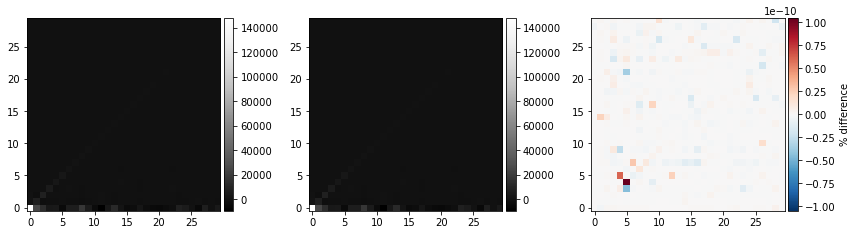

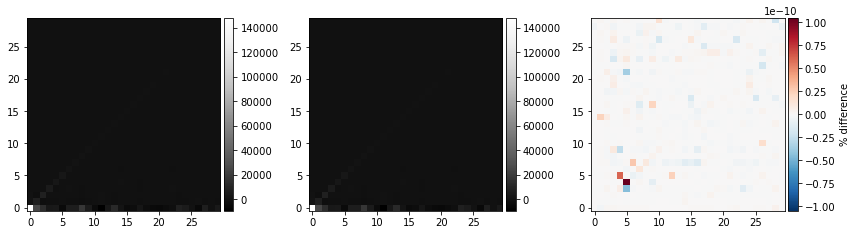

In [145]:
dd.three_panel_diff_plot(mtx_uprime @ mtx_sprime @ mtx_vprime.T, mtx_k)

False

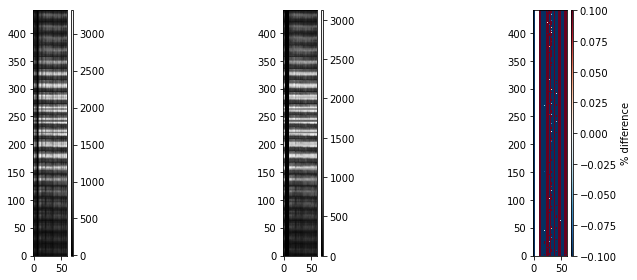

In [146]:
mtx_x_downdate_trick = mtx_u @ mtx_uprime @ mtx_sprime @ (mtx_v @ mtx_vprime).T
dd.three_panel_diff_plot(mtx_x_downdate_trick, mtx_xprime)
np.allclose(mtx_x_downdate_trick, mtx_xprime)

In [147]:
((mtx_u @ mtx_uprime).T @ mtx_xprime).shape

(30, 61)

$$
    \tilde{x}_i = (U U') (U U')^T x_i
$$

where $x_i$ are the columns of $X'$

$$
\tilde{X'} = 
\begin{bmatrix}
    | &  & |\\
    UU^T x_1 & ... & UU^T x_n\\
    | & & |
\end{bmatrix}
$$

Initial projection

$$
\begin{bmatrix}
    | &  & |\\
    U^T x_1 & ... & U^T x_n\\
    | & & |
\end{bmatrix}
$$ 

In [148]:
temp_mtx_u = (mtx_u @ mtx_uprime)
temp_mtx_u.shape

(441, 30)

In [149]:
(temp_mtx_u.T @ mtx_xprime[:,0]).shape

(30,)

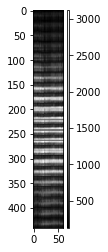

In [150]:
dd.matshow(temp_mtx_u @ (temp_mtx_u.T @ mtx_x))

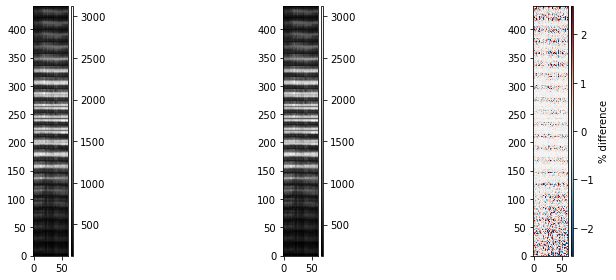

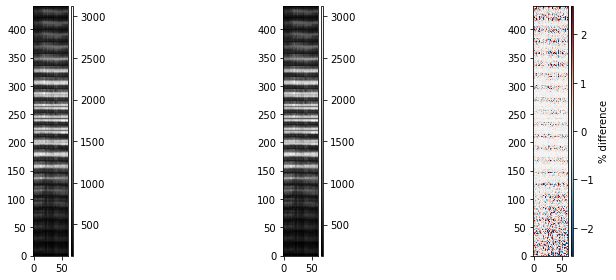

In [151]:
dd.three_panel_diff_plot(temp_mtx_u @ (temp_mtx_u.T @ mtx_x), mtx_x, diff_kwargs={'clip_percentile': 99})

In [160]:
from trick import downdate, minimal_downdate
idxs_to_remove = np.arange(drop_min, drop_max)
dd_mtx_u, dd_diag_s, dd_mtx_v = downdate(mtx_u, diag_s, mtx_v, col_data_to_remove=mtx_x[:,idxs_to_remove], col_idxs_to_remove=idxs_to_remove)
dd_recons = dd_mtx_u @ (dd_mtx_u.T @ mtx_x)
mdd_mtx_u, mdd_diag_s, mdd_mtx_v = minimal_downdate(mtx_u, diag_s, mtx_v, col_data_to_remove=mtx_x[:,idxs_to_remove], col_idxs_to_remove=idxs_to_remove)
mdd_recons = mdd_mtx_u @ (mdd_mtx_u.T @ mtx_x)

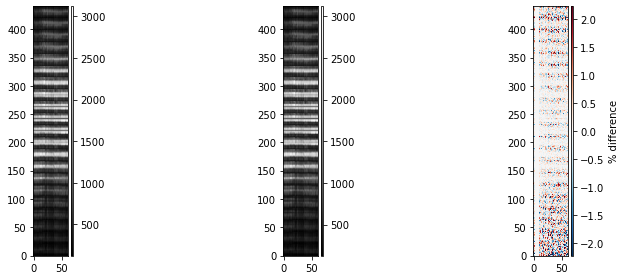

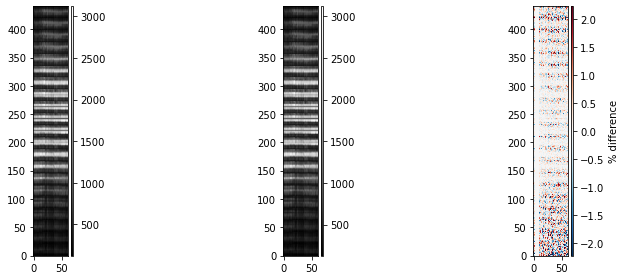

In [153]:
dd.three_panel_diff_plot(dd_mtx_u @ (dd_mtx_u.T @ mtx_x), mtx_x, diff_kwargs={'clip_percentile': 99})

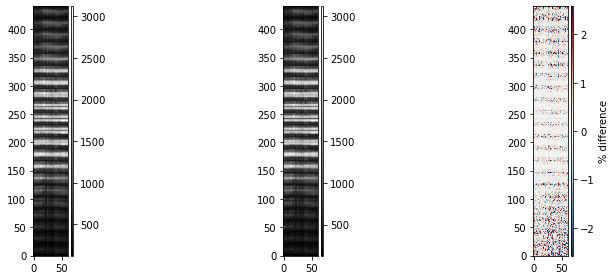

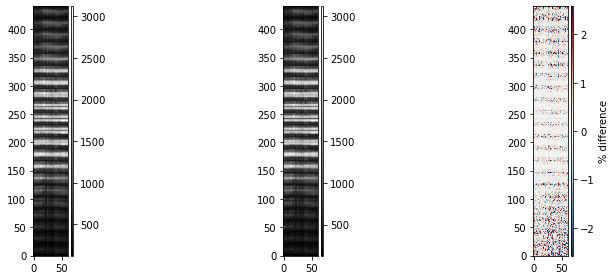

In [159]:
dd.three_panel_diff_plot(mdd_mtx_u @ (mdd_mtx_u.T @ mtx_x), mtx_x, diff_kwargs={'clip_percentile': 99})

In [161]:
np.std(mdd_recons - dd_recons)

2.3409712

In [156]:
np.average(mtx_x)

846.5096

In [157]:
diag_s.shape

(30,)

In [158]:
tempt_

NameError: name 'tempt_' is not defined

In [ ]:
np.allclose(mtx_xprime[:,0], ((mtx_u @ mtx_uprime) @ ((mtx_u @ mtx_uprime).T @ mtx_xprime))[:,0])

In [ ]:
dd_frame = ((mtx_u @ mtx_uprime) @ ((mtx_u @ mtx_uprime).T @ mtx_xprime[:,0])).reshape(image_shape)
ref_frame = mtx_xprime[:,0].reshape(image_shape)
dd.three_panel_diff_plot(dd_frame, ref_frame, diff_kwargs={'as_percent': False})

In [ ]:
dd.three_panel_diff_plot(mtx_u @ mtx_uprime, mtx_u_final[:,:dim_r], diff_kwargs={'vmax': 100})

In [ ]:
# compare_u(mtx_u @ mtx_uprime, mtx_u_final[:dim_r], display=True, first_n=3)

In [ ]:
dd.matshow((mtx_u @ mtx_uprime).T @ (mtx_u @ mtx_uprime))

In [ ]:
np.random.randn?